# DD2437
## Lab 1B - Part I

**Group 26**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from ipywidgets import interact, IntSlider, fixed, Play, ToggleButtons
from matplotlib.ticker import MaxNLocator

In [2]:
# Set seed
np.random.seed(42)

## HYPERPARAMETER TUNNING

In [3]:
nodes_hidden_layer = 0#4
nodes_output_layer = 1
number_iterations = 1
step_length = 1
number_epochs = 100
learning_rate = 0.05
alpha = 0.9

In [4]:
def transfer_function(x):
  return 2/(1+np.exp(-x))-1

def der_transfer_function(x):
  phi = transfer_function(x)
  return (1+phi)*(1-phi)/2

### 3.1.1 Classification of linearly non-separable data

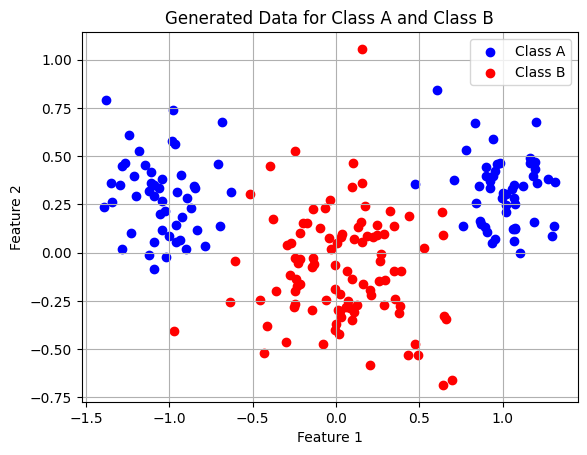

In [5]:
n = 100
mA = np.array([1.0, 0.3])
mB = np.array([0.0, -0.1])
sigmaA = 0.2
sigmaB = 0.3
half_1 = np.random.randn(int(np.round(0.5*n)),1) * sigmaA - mA[0]
half_2 = np.random.randn(int(np.round(0.5*n)),1) * sigmaA + mA[0]
classA_0 = np.vstack((half_1, half_2))
classA_1 = np.random.randn(n,1) * sigmaA + mA[1]
classA = np.hstack((classA_0, classA_1))
classB = np.random.randn(n, 2) * sigmaB + mB

plt.scatter(classA[:, 0], classA[:, 1], color='blue', label='Class A')
plt.scatter(classB[:, 0], classB[:, 1], color='red', label='Class B')
plt.title('Generated Data for Class A and Class B')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()

In [6]:
def forward_pass(w, v, X):
  '''Hidden layer'''
  ones = np.ones(X.shape[1]).reshape((1, X.shape[1]))
  # print(X.shape,ones.shape)
  X_in = np.vstack((X, ones))
  # print(X_in, X_in.shape)
  h_in = np.dot(w,X_in) # (hidden,2n)
  # print(h_in, h_in.shape)
  h_out = transfer_function(h_in) #(hidden, 2n)
  # print(h_out, h_out.shape)
  '''Output layer'''
  H = np.vstack((h_out, ones))
  # print(H, H.shape)
  o_in = np.dot(v,H)
  # print(o_in, o_in.shape)
  o_out = transfer_function(o_in)
  # print(o_out, o_out.shape)
  return h_in, h_out, o_in, o_out, X_in, H

def backward_pass(h_in, h_out, o_in, o_out, t, v):
  phi_dot_o = der_transfer_function(o_in)
  delta_o = np.multiply((o_out - t), phi_dot_o)
  # print(delta_o, delta_o.shape)
  phi_dot_h = der_transfer_function(h_in)
  delta_h = np.multiply((np.dot(np.transpose(v[:,:-1]),delta_o)),phi_dot_h) # WE DON'T USE THE BIAS COLUMN FROM THE V MATRIX!!!
  # print(delta_h, delta_h.shape)
  return delta_o, delta_h

def backprop(classA_train, classB_train, hidden_dim, classA_val=None, classB_val=None, batch_size=None):

  X_train = np.vstack((classA_train, classB_train))
  t_train = np.hstack((-np.ones(classA_train.shape[0]), np.ones(classB_train.shape[0])))
  perm = np.random.permutation(X_train.shape[0])
  X_train, t_train = X_train[perm], t_train[perm]
  X_train = np.transpose(X_train) # (2,2n)
  t_train = np.transpose(t_train) # (1,2n)

  '''
  If validation data is provided, use it. Otherwise,
  we reuse training data for validation.
  '''
  if classA_val is not None and classB_val is not None:
    X_val = np.vstack((classA_val, classB_val))
    t_val = np.hstack((-np.ones(classA_val.shape[0]), np.ones(classB_val.shape[0])))
    perm = np.random.permutation(X_val.shape[0])
    X_val, t_val = X_val[perm], t_val[perm]
    X_val = np.transpose(X_val) # (2,2n)
    t_val = np.transpose(t_val) # (1,2n)
  else:
    X_val = X_train
    t_val = t_train

  w_history = []
  v_history = []
  classification_accuracy_history = []
  mse_history = []
  w = np.random.random((hidden_dim,3)).reshape(hidden_dim,3) #(hidden, 2+bias)
  v = np.random.random((nodes_output_layer, hidden_dim+1)).reshape(nodes_output_layer,hidden_dim+1) #(output, hidden+bias)
  # print(f'W: {w}, {w.shape}')
  # print(f'V: {v}, {v.shape}')
  delta_w = 0
  delta_v = 0
  # For each epoch
  for _ in range(number_epochs):
    # For each batch (unless batch_size is None, then we use the whole set)
    for i in range(0, X_train.shape[1], batch_size if batch_size is not None else X_train.shape[1]):
      if batch_size is not None:
        X_batch = X_train[:, i:i+batch_size]
        t_batch = t_train[i:i+batch_size]
      else:
        X_batch = X_train
        t_batch = t_train
      '''1st: FORWARD PASS: Activities of the nodes are computed layer for layer'''
      h_in, h_out, o_in, o_out, X_bias, H_bias = forward_pass(w, v, X_batch)
      ''' 2nd: BACKWARD PASS: Error signal (delta) computed for each node'''
      delta_o, delta_h = backward_pass(h_in, h_out, o_in, o_out, t_batch, v)
      ''' 3rd: WEIGHT UPDATE'''
      delta_w = delta_w*alpha - (1-alpha)*np.dot(delta_h, np.transpose(X_bias))
      delta_v = delta_v*alpha - (1-alpha)*np.dot(delta_o, np.transpose(H_bias))
      # print(delta_v)
      w += learning_rate*delta_w
      v += learning_rate*delta_v
      # print(v)
    # We only check accuracy and MSE after each epoch, not for each batch
    classification_accuracy_history.append(check_accuracy(w,v,X_val,t_val))
    mse_history.append(mse(w,v,X_val,t_val))
    w_history.append(w.copy())
    v_history.append(v.copy())
    #print(f'Epoch {_+1}/{number_epochs} - Accuracy: {accuracy*100:.2f}%')
  hidden_node_accuracy = check_accuracy(w,v,X_val,t_val)
  # print(v_history)
  return np.array(w_history), np.array(v_history), np.array(classification_accuracy_history), np.array(mse_history), hidden_node_accuracy


def check_accuracy(w,v,X,t):
  _, _, Z_data, _, _, _ = forward_pass(w, v, X)
  labels_pred = np.sign(Z_data).flatten()
  correct = 0
  for i in range(labels_pred.shape[0]):
      if labels_pred[i] == t[i]:
          correct += 1
  return correct / X.shape[1]

'''
Mean Squared Error accuracy function
Follows the formula: MSE = 1/N * sum((t - Z_data)^2) / 4
Note that we're dividing by 4 to account for worst case
scenario where t = 1 and Z_data = -1.
'''
def mse(w, v, X, t):
  _, _, Z_data, _, _, _ = forward_pass(w, v, X)
  labels_pred = np.sign(Z_data).flatten()
  return np.mean((t - labels_pred)**2) / 4

#### Hidden nodes effect

In [7]:
def plot_decision_boundary(epoch_idx, title, w_history, v_history, classA, classB, hidden_dim):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot data points
    ax.scatter(classA[:, 0], classA[:, 1], color='blue', label='Class A')
    ax.scatter(classB[:, 0], classB[:, 1], color='red', label='Class B')

    # Then we create the decision boundary line
    x_boundry = np.linspace(-3, 3, 100)
    w = np.array(w_history[epoch_idx]).reshape(hidden_dim,3)
    v = np.array(v_history[epoch_idx]).reshape(nodes_output_layer, hidden_dim+1)
    # print(w, w.shape)
    # print(v,v.shape)

    xx, yy = np.meshgrid(
    np.linspace(-2, 2, 400),
    np.linspace(-2, 2, 400)
          )
    X_grid = np.vstack([xx.ravel(), yy.ravel()])

    _, _, o_in, _, _, _ = forward_pass(w, v, X_grid)

    Z = o_in
    Z_plot = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z_plot, levels=50, cmap='coolwarm', alpha=0.4)
    plt.contour(xx, yy, Z_plot, levels=[0], colors='black', linewidths=2)

    '''OBSERVING BOUNDARIES FROM INPUT TO HIDDEN LAYER'''
    # for i in range(hidden_dim):
    #   y_boundry = - (w[i,0]/w[i,1]) * x_boundry - (w[i,2]/w[i,1])
    #   ax.plot(x_boundry, y_boundry, label=f"Decision boundary {i}")

    '''OBSERVING BOUNDARIES FROM INPUT TO OUTPUT LAYER'''
    # for i in range(nodes_output_layer):
    #   v_a = v[:,:-1]
    #   print(f"v_a: {v_a}, {v_a.shape}")
    #   const_1 = (np.dot(v_a[i,:],w[:,0])).T #Not necessary T
    #   const_2 = (np.dot(w[:,2].T,v_a[i,:]) + v[i,-1])
    #   const_den = (np.dot(v_a[i,:],w[:,1])).T #Not necessary T
    #   # print(const_2)
    #   y_boundry = - x_boundry *  const_1/const_den- const_2/const_den
    #   ax.plot(x_boundry, y_boundry, label=f"Decision boundary {i}")

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.legend()
    ax.set_title(title)


def plot_accuracy(mse_history, classification_accuracy_history, title, title_suffix=''):
    plt.figure(figsize=(8, 5))
    plt.plot(classification_accuracy_history, label='Classification Accuracy')
    plt.plot(mse_history, label='MSE')
    plt.title(title + " " + title_suffix)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.show()

def plot_node_accuracy(node_accuracy_history, title, title_suffix=''):
    plt.figure(figsize=(8, 5))
    plt.plot(node_accuracy_history, label='Accuracy')
    plt.title(title + " " + title_suffix)
    plt.xlabel('Number of hidden layer nodes')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.show()

In [8]:
def train_and_evaluate(classA_train, classB_train, classA_val=None, classB_val=None, title_suffix='', batch_size=None, desired_nodes_hidden_layers = [1]):
  hidden_node_accuracy_history = []
  for i in desired_nodes_hidden_layers:
    w_history, v_history, classification_accuracy_history, mse_history, hidden_node_accuracy= backprop(classA_train, classB_train, i, classA_val, classB_val, batch_size=batch_size)
    title = f'Backprop with two-layer perceptron network (Hidden layer: {i})'
    if classA_val is None and classB_val is None: #In order to plot something
      classA_plot = classA_train
      classB_plot = classB_train
    else:
      classA_plot = classA_val
      classB_plot = classB_val
    plot_decision_boundary(epoch_idx=number_epochs-1,
                          title=title,
                          w_history=w_history,
                          v_history=v_history,
                          classA=classA_plot,
                          classB=classB_plot,
                          hidden_dim=i)
    plot_accuracy(mse_history, classification_accuracy_history, title, title_suffix)
    hidden_node_accuracy_history.append(hidden_node_accuracy)
    # print(np.array(hidden_node_accuracy_history).shape)
  plot_node_accuracy(np.array(hidden_node_accuracy_history), f'Backdrop accuracy of two-layer perceptron network (Epoch:{number_epochs})')

In [9]:
'''
Split Data takes a list of data points and divides it
into two groups: training data and validation data,
based on a ration 0-1.
'''
def split_data(data, n_train):
    # Shuffle data identically each time
    np.random.seed(42)
    perm = np.random.permutation(data.shape[0])
    data = data[perm]
    # Calculate split
    n = data.shape[0] * n_train // 1
    n = int(n)
    train_data = data[:n]
    val_data = data[n:]
    return train_data, val_data

### All data for training and vadliation

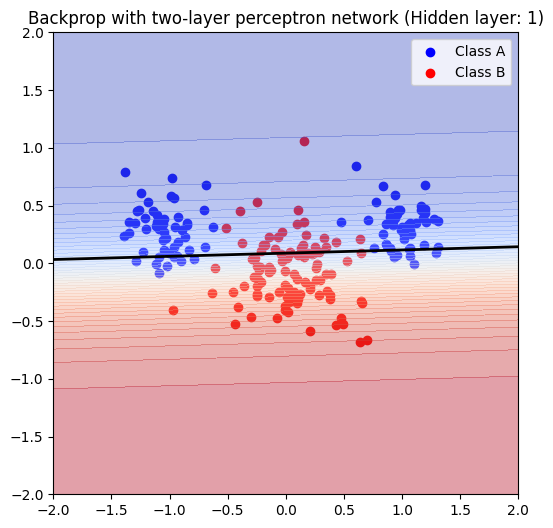

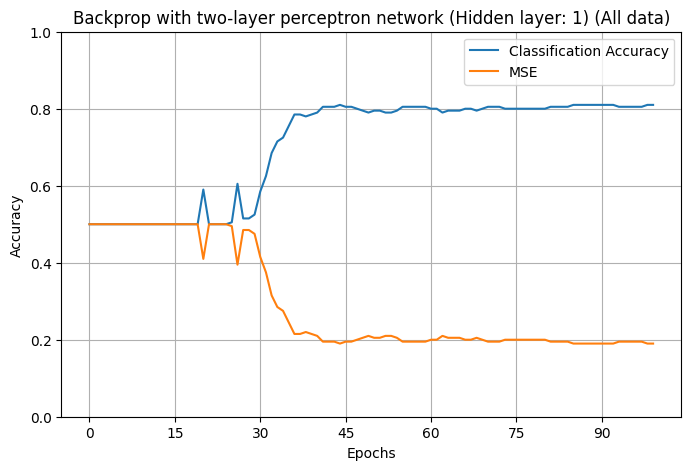

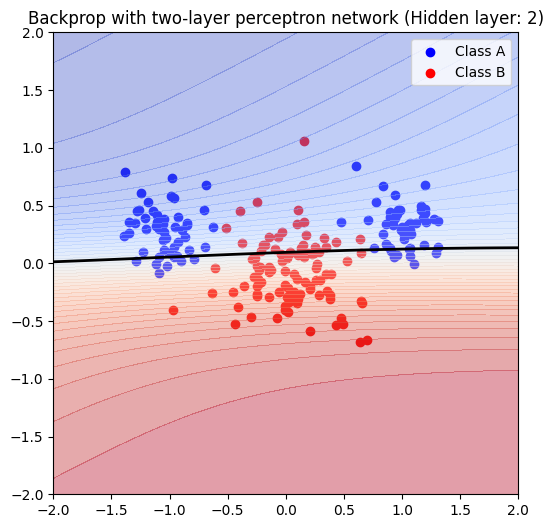

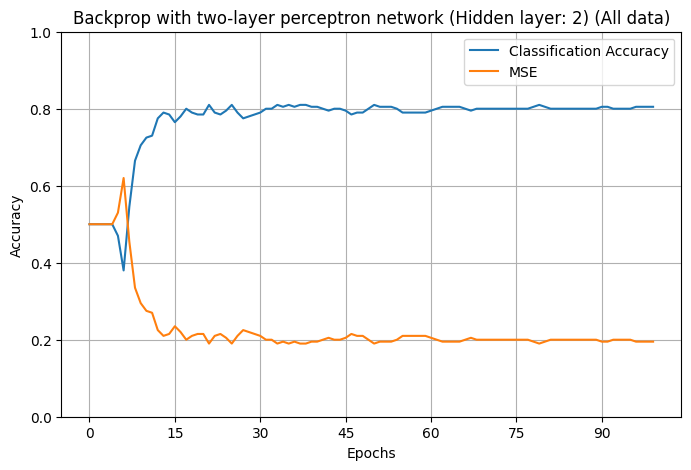

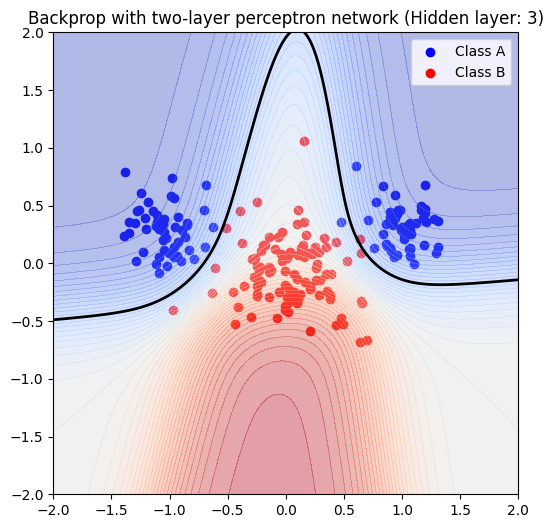

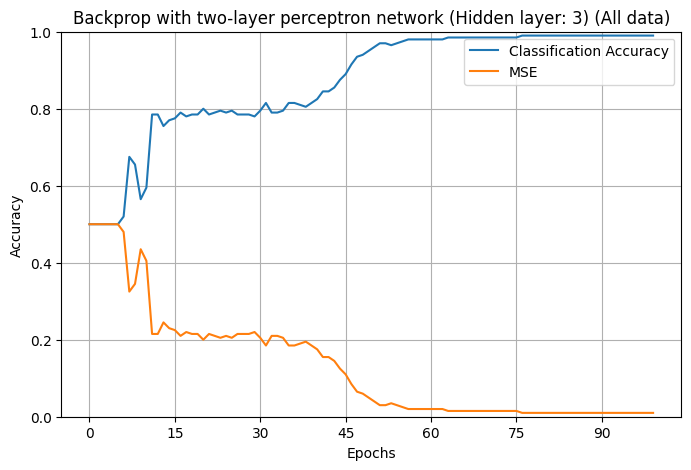

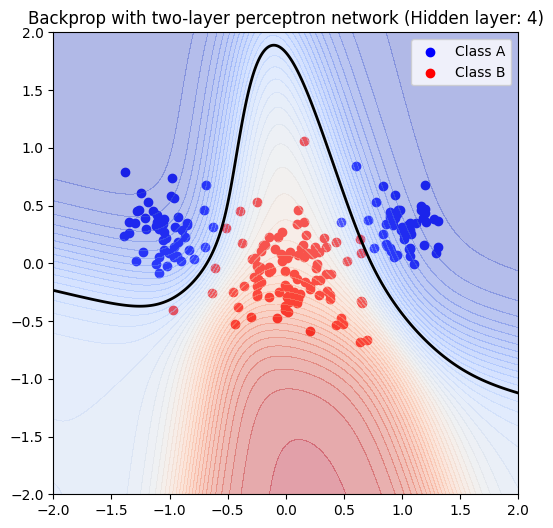

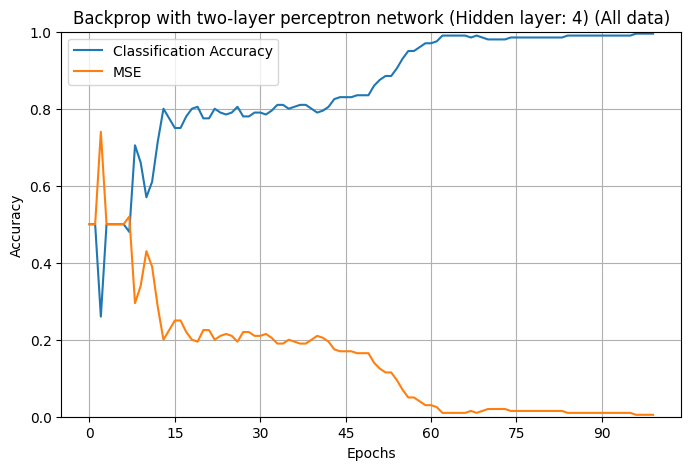

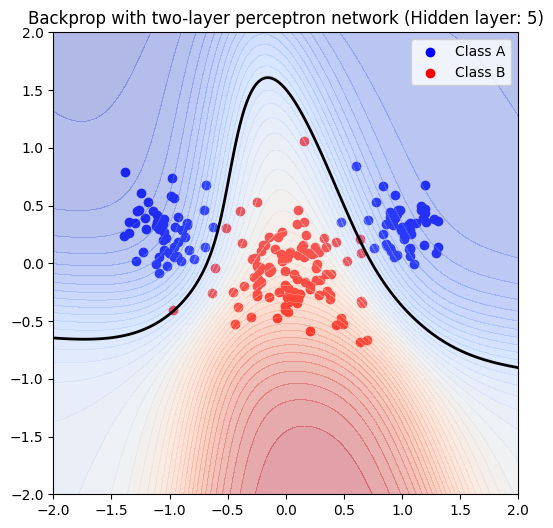

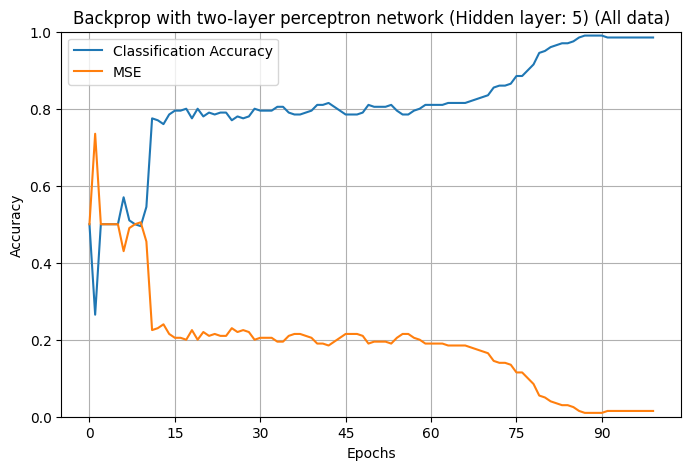

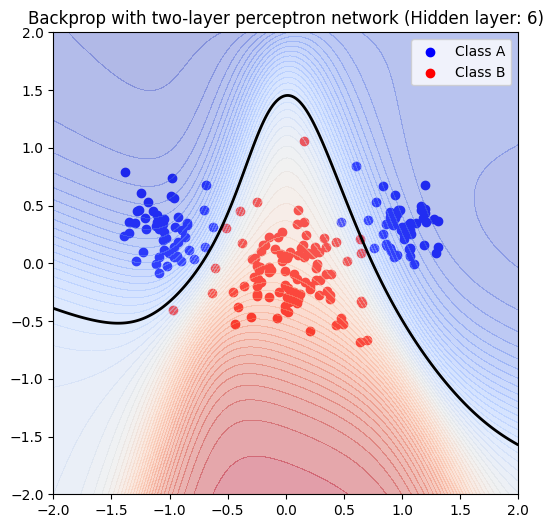

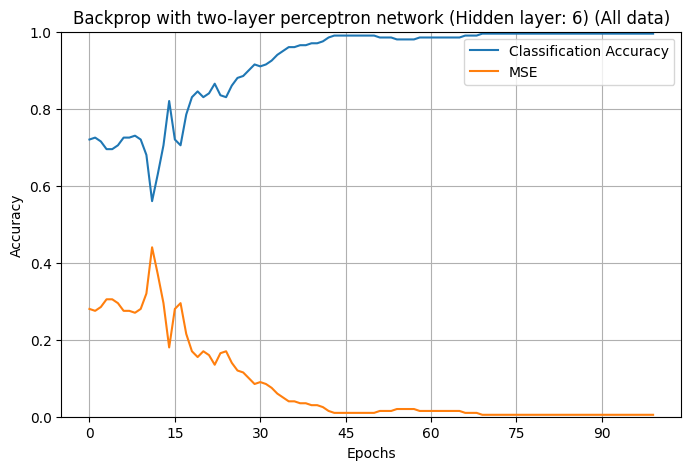

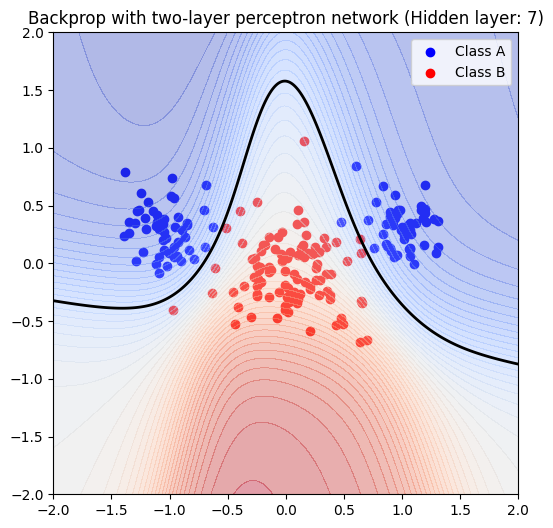

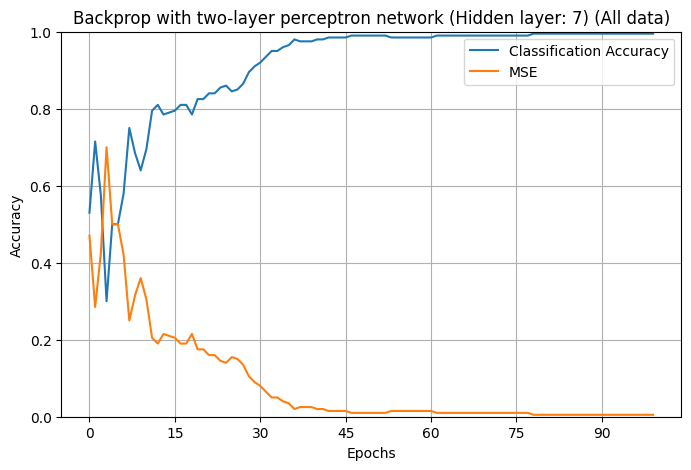

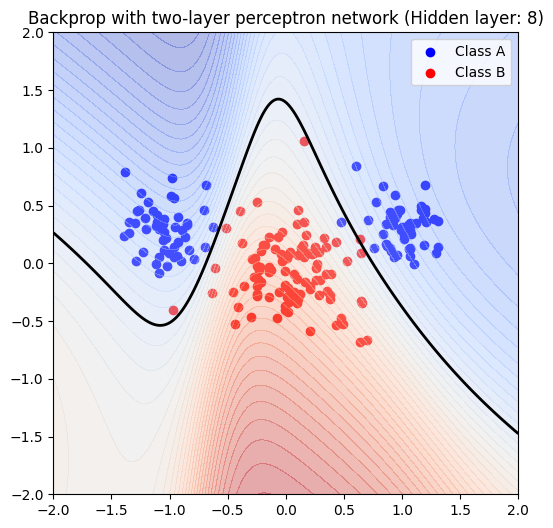

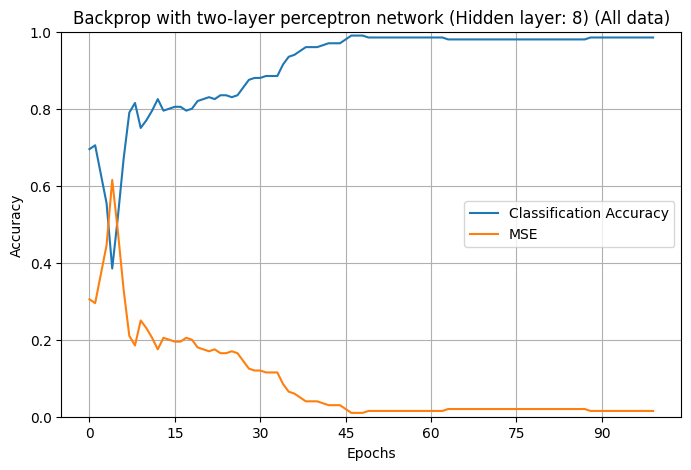

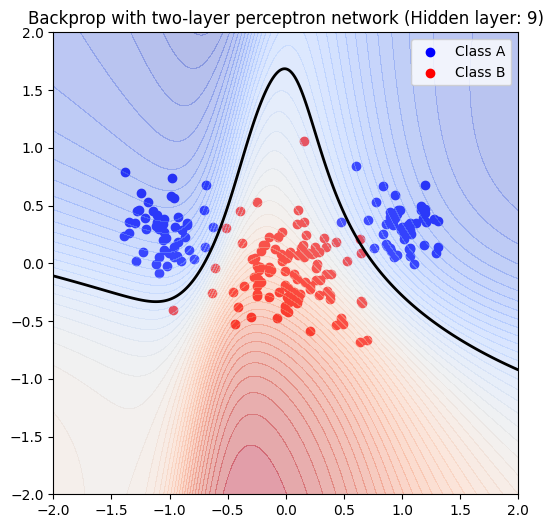

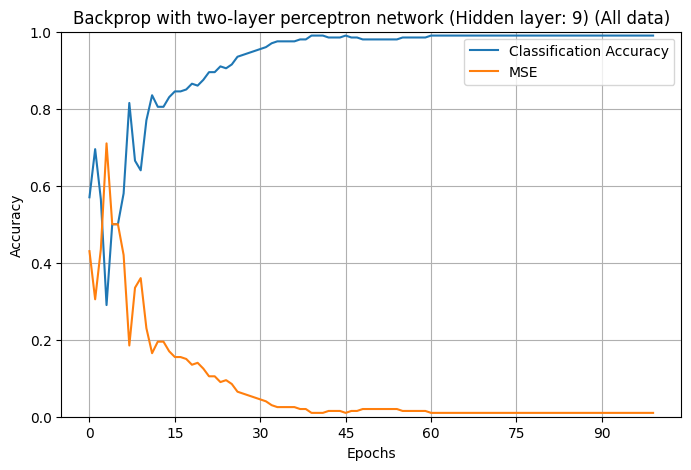

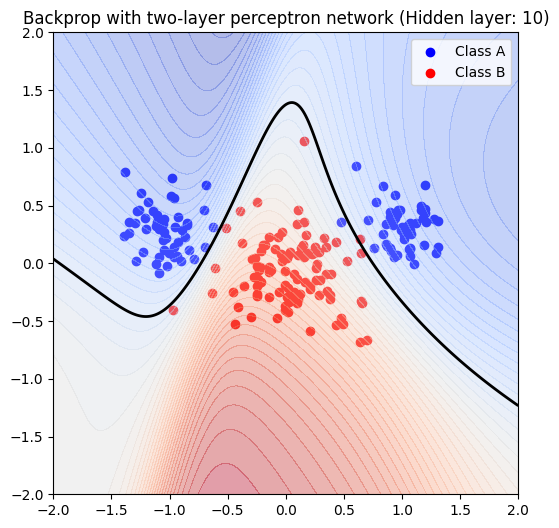

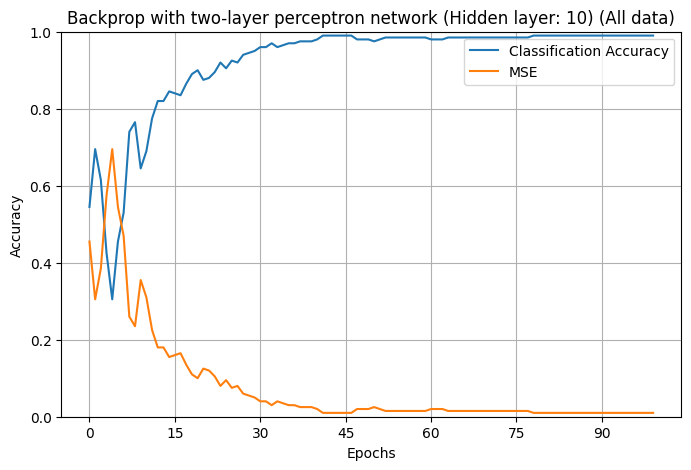

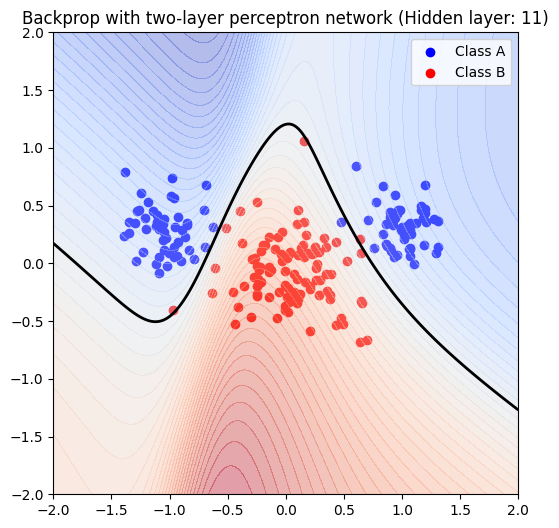

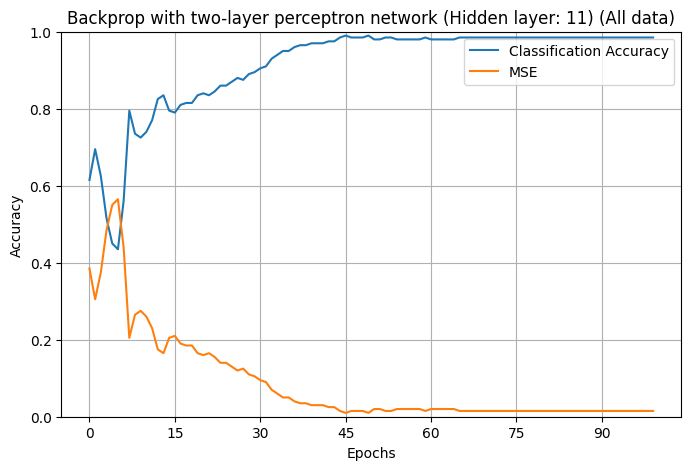

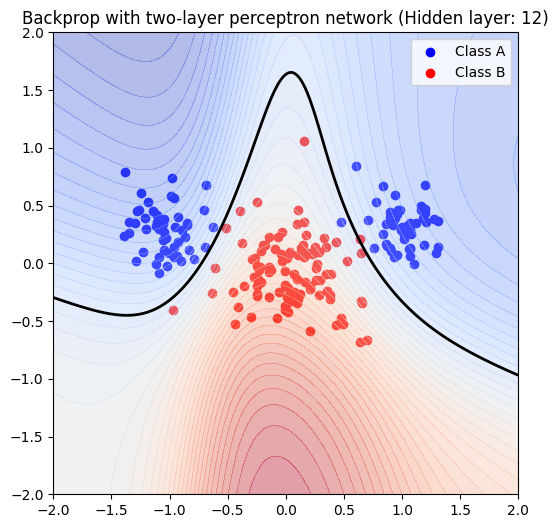

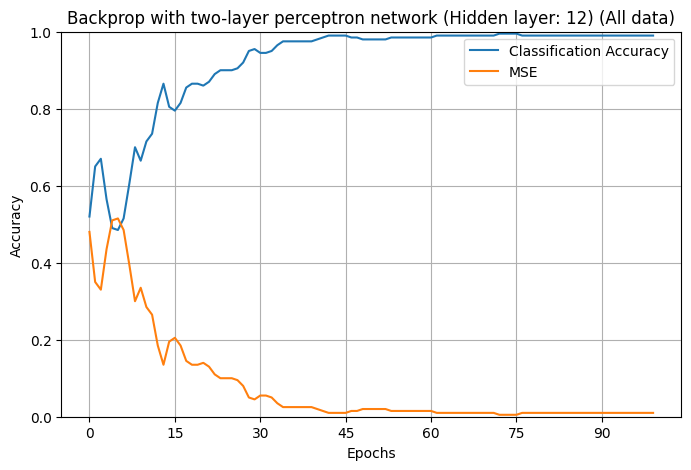

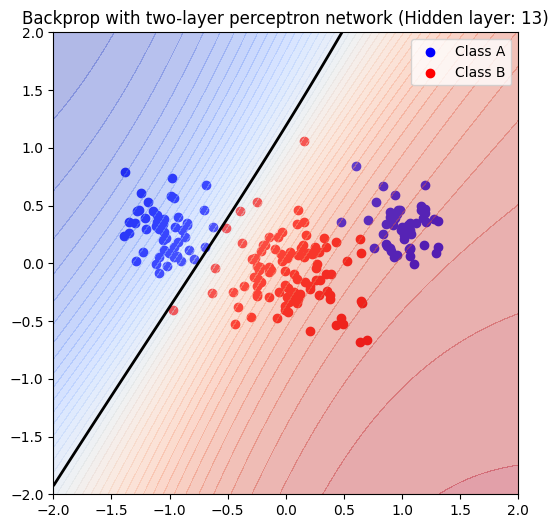

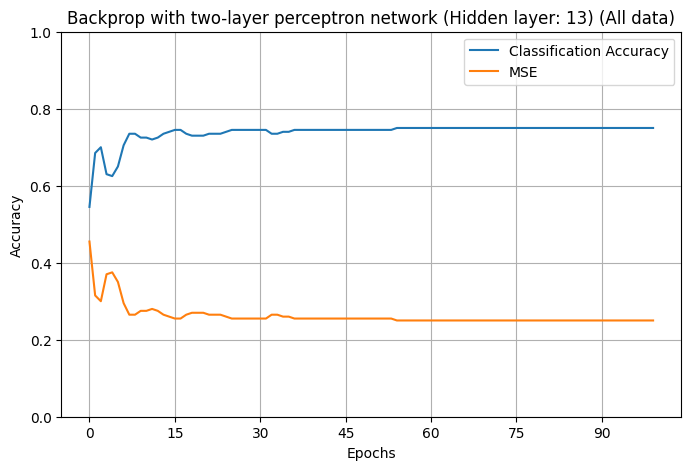

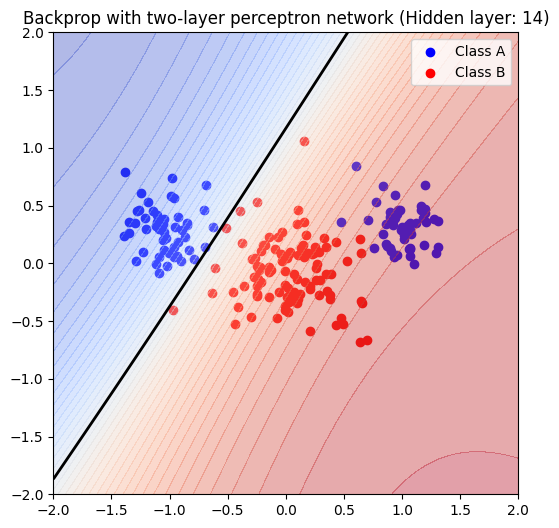

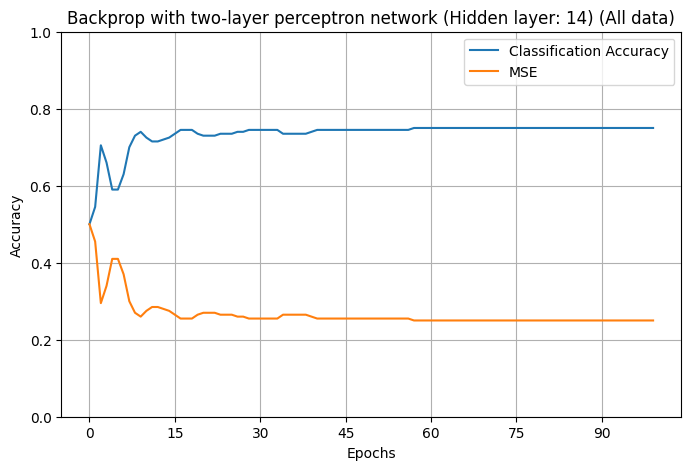

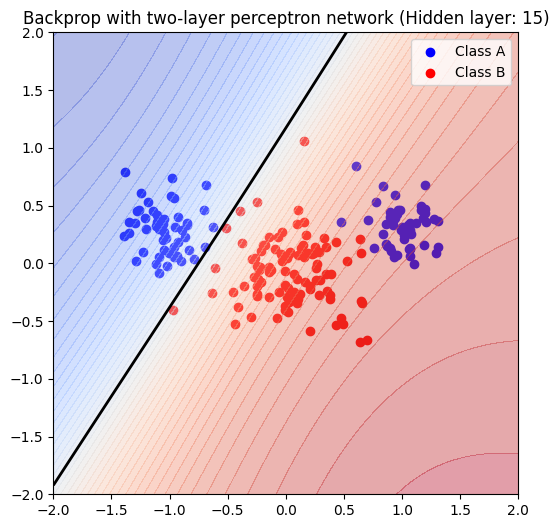

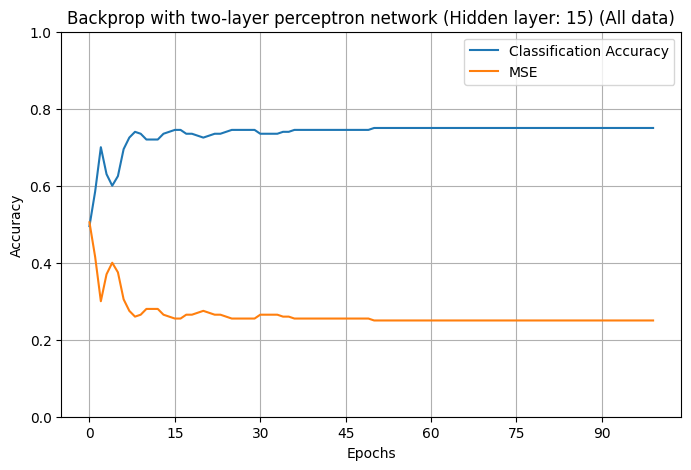

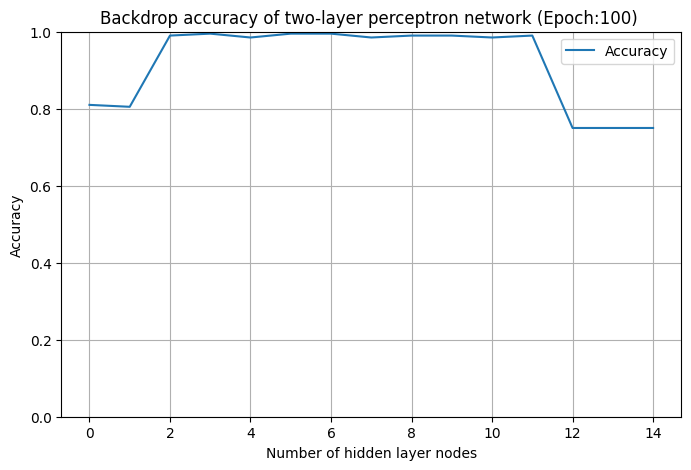

In [10]:
train_and_evaluate(classA, classB, title_suffix='(All data)', desired_nodes_hidden_layers=range(1,16))

### Random 75/25 split

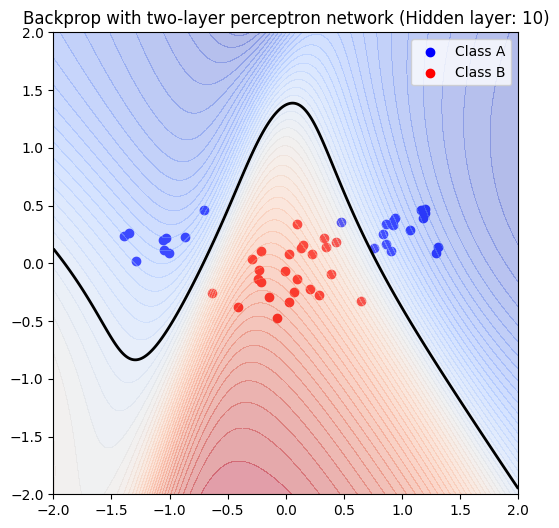

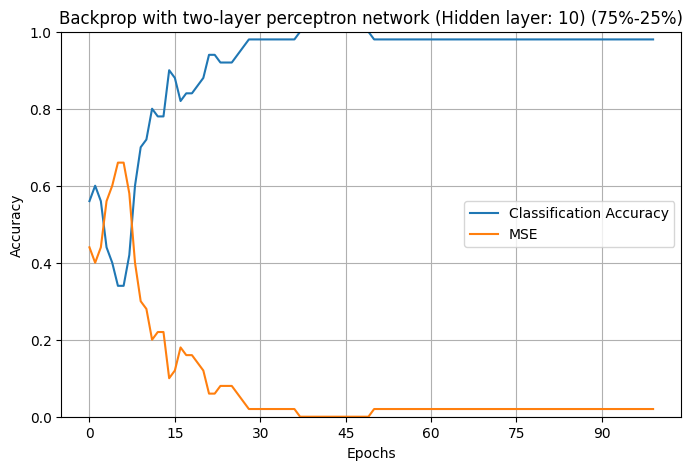

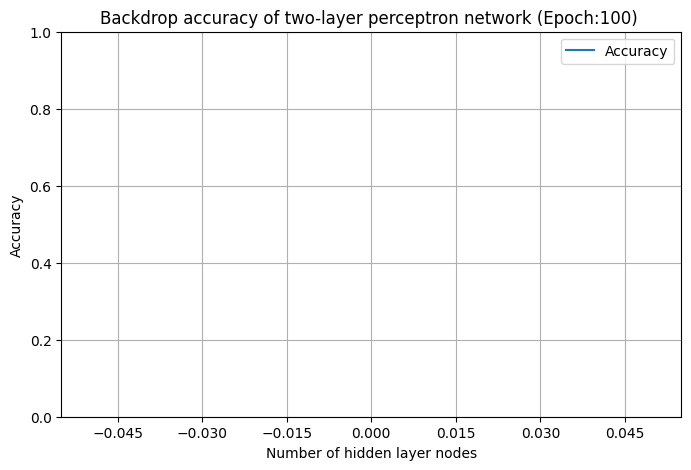

In [11]:
classA_train, classA_val = split_data(classA, 0.75)
classB_train, classB_val = split_data(classB, 0.75)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(75%-25%)', desired_nodes_hidden_layers=[10])

### Random 50/50 split

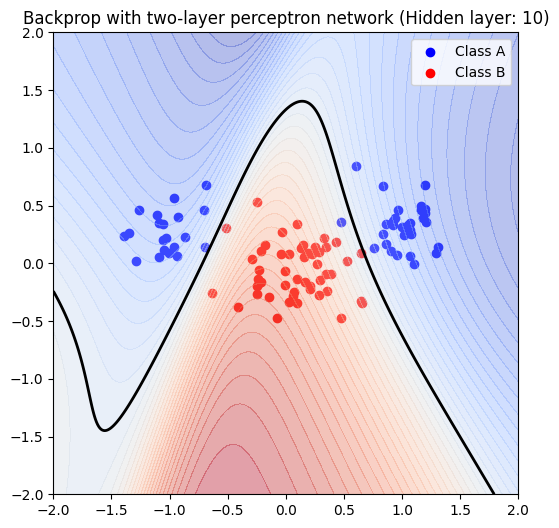

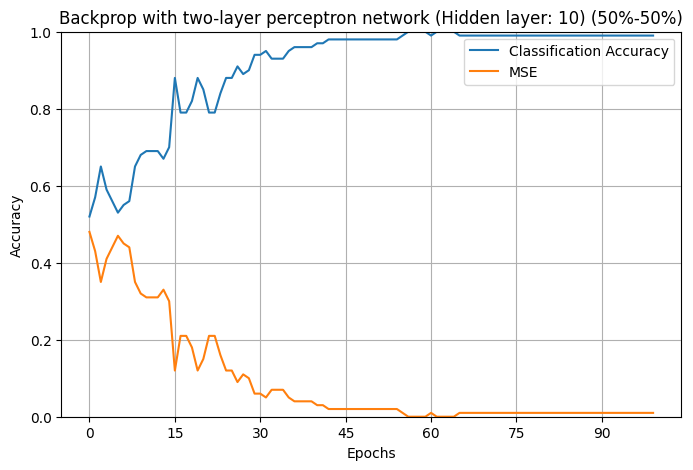

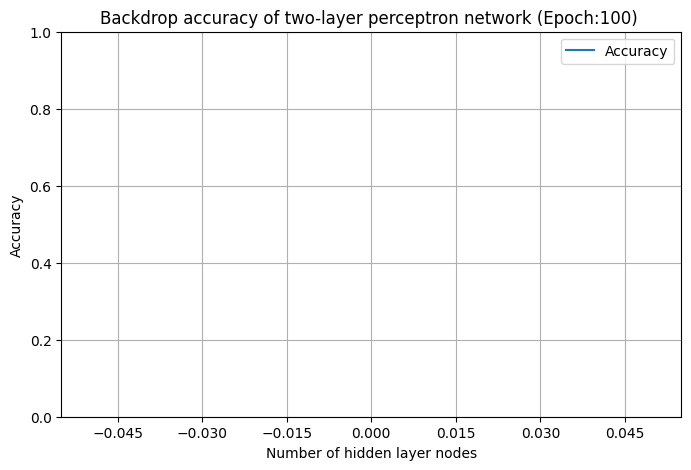

In [12]:
classA_train, classA_val = split_data(classA, 0.50)
classB_train, classB_val = split_data(classB, 0.50)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(50%-50%)', desired_nodes_hidden_layers=[10])

### 20% from subset 1 of A and 80% form subset 2 of A

classA_train.shape: (50, 2)
classA_val.shape: (50, 2)


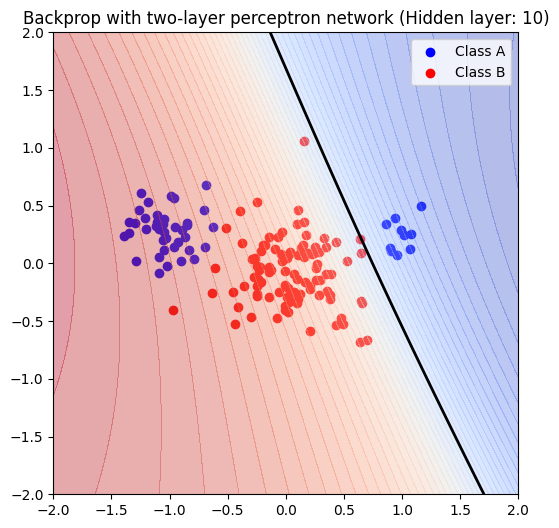

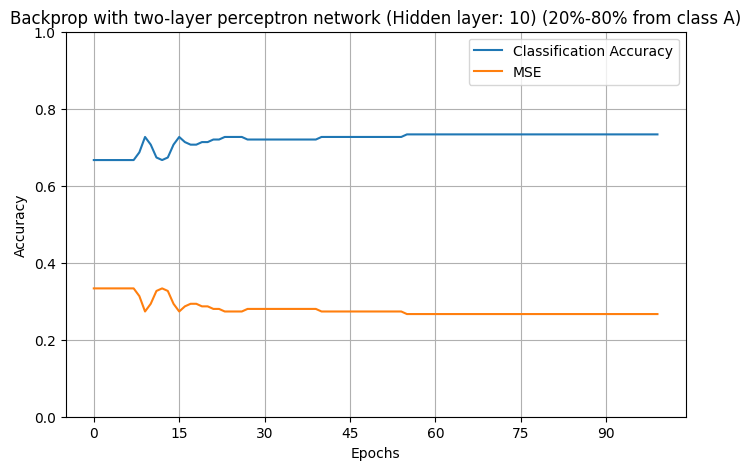

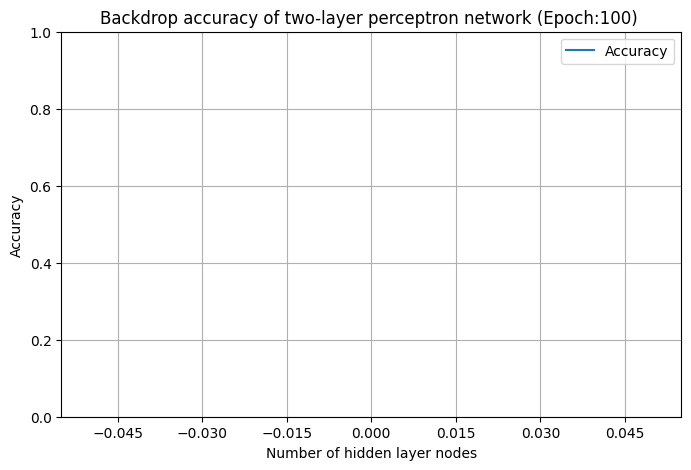

In [13]:
'''
Note that we manually split classA into two parts to regain the
old two groups where first half has mean at -1 and second half at +1.
Then we split those two halves into training and validation sets
with 20%-80% and combine them back together.
'''
classA_one_train, classA_one_val = split_data(classA[:int(np.round(0.5*n))], 0.20)
classA_two_train, classA_two_val = split_data(classA[int(np.round(0.5*n)):], 0.80)
classA_train = np.vstack((classA_one_train, classA_two_train))
classA_val = np.vstack((classA_one_val, classA_two_val))
classB_train = classB
classB_val = classB
print("classA_train.shape:", classA_train.shape)
print("classA_val.shape:", classA_val.shape)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(20%-80% from class A)', desired_nodes_hidden_layers=[10])

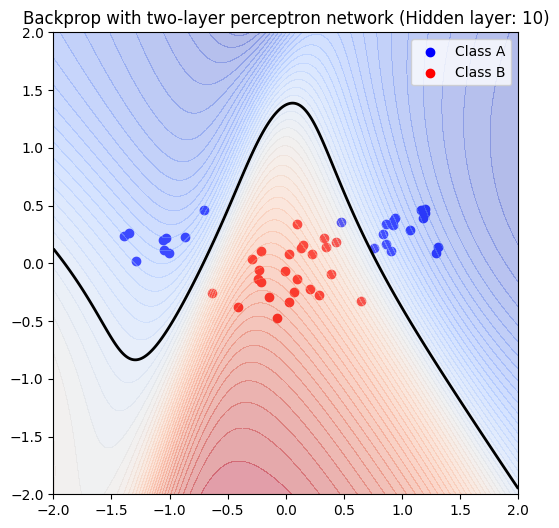

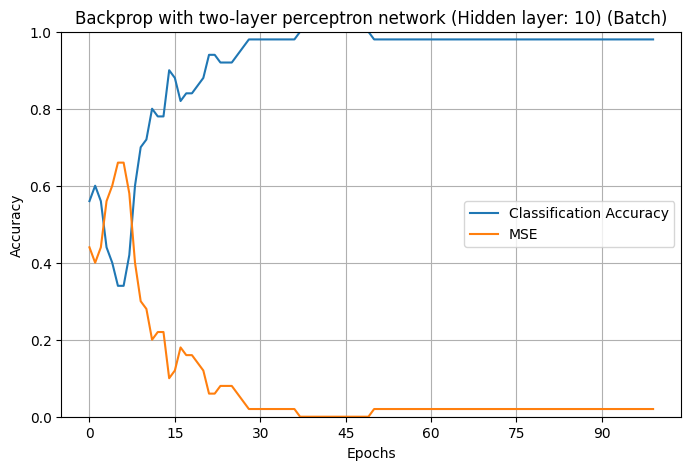

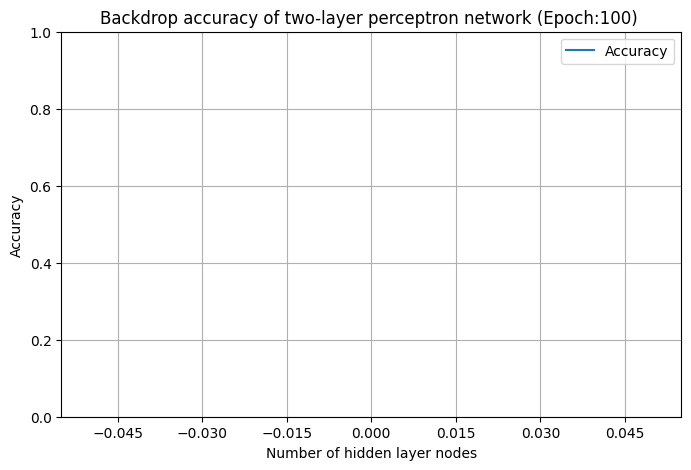

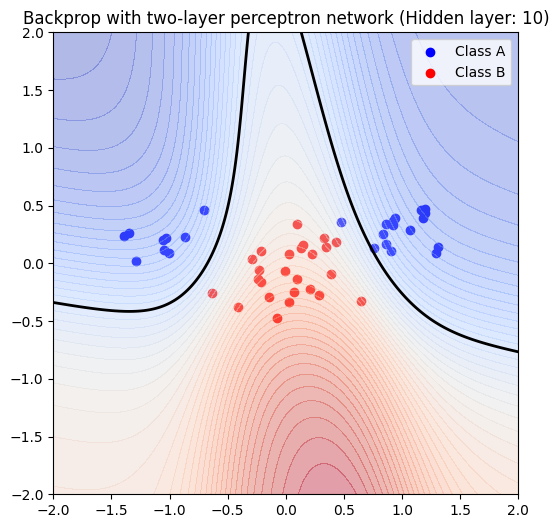

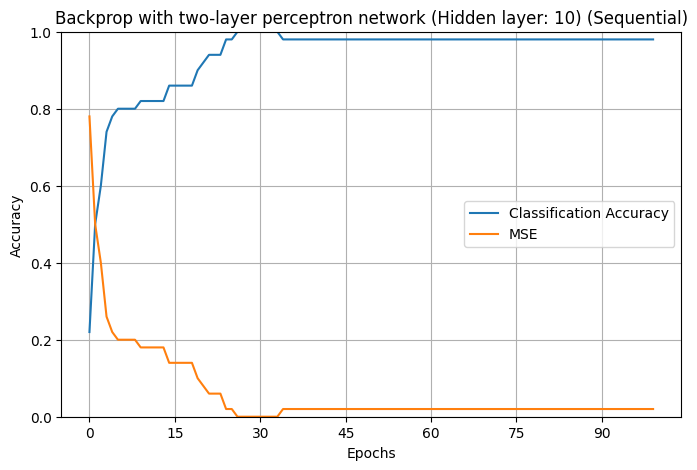

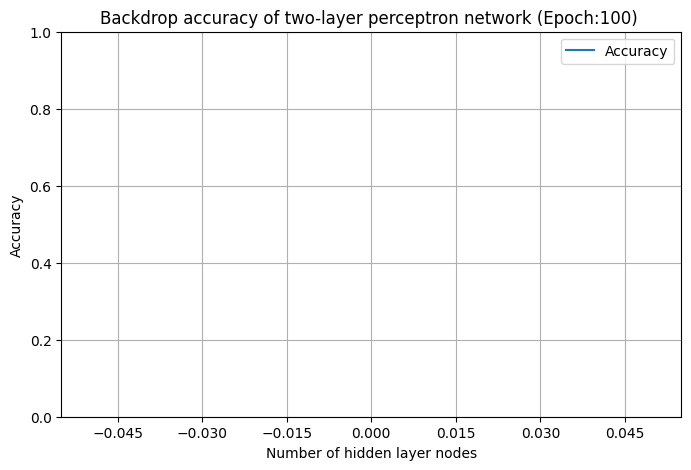

In [14]:
'''
Exploring the different in terms of validation results comparing
batch vs sequential updates. Where batch is the whole training.
'''
classA_train, classA_val = split_data(classA, 0.75)
classB_train, classB_val = split_data(classB, 0.75)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(Batch)', batch_size=None, desired_nodes_hidden_layers=[10])
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(Sequential)', batch_size=1, desired_nodes_hidden_layers=[10])

In [39]:
from matplotlib import cm

def gauss_func(x,y):
  return np.exp(-(x**2+y**2)/10)-0.5


def pattern_target_generator(xx,yy):
  z = gauss_func(xx,yy)
  # print(xx.shape)

  # fig = plt.figure()
  # ax = plt.axes(projection='3d')
  # ax.plot_surface(xx, yy, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
  # ax.set_xlabel('x')
  # ax.set_ylabel('y')
  # ax.set_zlabel('z');

  ndata = len(xx[0])*len(yy[0])
  targets = z.reshape((1,ndata))
  patterns = np.vstack((xx.reshape((1,ndata)), yy.reshape((1,ndata))))
  # print(f"X_train: {patterns.shape}")
  # print(f"Target: {targets.shape}")
  return patterns,targets

def check_accuracy_gauss(w,v,X,t):
  _, _, Z_data, _, _, _ = forward_pass(w, v, X)
  labels_pred = Z_data.flatten()
  t_flat = t.flatten()
  # print(labels_pred.shape)
  # print(t.shape)
  correct = 0
  for i in range(labels_pred.shape[0]):
      if labels_pred[i] == t_flat[i]:
          correct += 1
  return correct / X.shape[1]

def plot_accuracy_gauss(mse_history, title, title_suffix=''):
    plt.figure(figsize=(8, 5))
    plt.plot(mse_history, label='MSE')
    plt.title(title + " " + title_suffix)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 0.5)
    plt.grid()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.show()


'''
Mean Squared Error accuracy function
Follows the formula: MSE = 1/N * sum((t - Z_data)^2) / 4
Note that we're dividing by 4 to account for worst case
scenario where t = 1 and Z_data = -1.
'''
def mse_gauss(w, v, X, t):
  _, _, _, Z_data, _, _ = forward_pass(w, v, X)
  labels_pred = Z_data.flatten()
  return np.mean((t.flatten() - labels_pred)**2) / 4

def dataset_splitter(X_full, t_full, percentage):
  if percentage == 0 or percentage is None:
    X_train = X_full
    t_train = t_full
    return X_train, t_train, None, None
  else:
    # subsamp = np.random.choice(X_full.shape[1], size = int(X_full.shape[1]*percentage), replace=False)
    # subsamp = np.sort(subsamp)
    # X_val = np.delete(X_full, subsamp, axis=1)
    # t_val = np.delete(t_full, subsamp, axis=1)
    # X_train = X_full[:,subsamp]
    # t_train = t_full[:,subsamp]
    subsamp = int(percentage * X_full.shape[1])
    X_train = X_full[:,:subsamp]
    t_train = t_full[:,:subsamp]
    X_val = X_full[:,subsamp:]
    t_val = t_full[:,subsamp:]

    return X_train, t_train, X_val, t_val

def backprop_gauss(X_full, t_full, hidden_dim, percentage=None, batch_size=None):

  X_train, t_train, X_val, t_val = dataset_splitter(X_full, t_full, percentage)

  perm = np.random.permutation(X_train.shape[1])
  X_train, t_train = X_train[:,perm], t_train[:,perm]
  '''
  If validation data is provided, use it. Otherwise,
  we reuse training data for validation.
  '''
  if X_val is not None:
    # x_v, y_v = x_val[0], x_val[1]
    # xx_v, yy_v = np.meshgrid(x_v,y_v)
    # X_val, t_val = pattern_target_generator(xx_v, yy_v) #SAME PROCESS AS WITH TRAINING
    perm_val = np.random.permutation(X_val.shape[1])
    X_val, t_val = X_val[:,perm_val], t_val[:,perm_val]
  else:
    X_val = X_train
    t_val = t_train

  gaussian_history = []
  w_history = []
  v_history = []
  classification_accuracy_history = []
  mse_history = []
  w = np.random.randn(hidden_dim,3).reshape(hidden_dim,3) #(hidden, 2+bias)
  v = np.random.randn(nodes_output_layer, hidden_dim+1).reshape(nodes_output_layer,hidden_dim+1) #(output, hidden+bias)
  delta_w = 0
  delta_v = 0

  # For each epoch
  for _ in range(number_epochs):
    # For each batch (unless batch_size is None, then we use the whole set)
    for i in range(0, X_train.shape[1], batch_size if batch_size is not None else X_train.shape[1]):
      if batch_size is not None:
        X_batch = X_train[:, i:i+batch_size]
        t_batch = t_train[i:i+batch_size]
      else:
        X_batch = X_train
        t_batch = t_train
      '''1st: FORWARD PASS: Activities of the nodes are computed layer for layer'''
      h_in, h_out, o_in, o_out, X_bias, H_bias = forward_pass(w, v, X_batch)

      if X_val is None:
        original_indices = np.argsort(perm)
        zz = o_out[:, original_indices].reshape(21, 21)
      else:
        ## WE COMPUTE THE OUTPUT WITH THE WHOLE DATASET
        _,_,_,o_out_full,_,_ = forward_pass(w,v,X_full)
        zz = o_out_full.reshape(21,21)

      gaussian_history.append(zz.copy())

      ''' 2nd: BACKWARD PASS: Error signal (delta) computed for each node'''
      delta_o, delta_h = backward_pass(h_in, h_out, o_in, o_out, t_batch, v)
      ''' 3rd: WEIGHT UPDATE'''
      delta_w = delta_w*alpha - (1-alpha)*np.dot(delta_h, np.transpose(X_bias))
      delta_v = delta_v*alpha - (1-alpha)*np.dot(delta_o, np.transpose(H_bias))
      w += learning_rate*delta_w
      v += learning_rate*delta_v

    # We only check accuracy and MSE after each epoch, not for each batch
    # classification_accuracy_history.append(check_accuracy_gauss(w,v,X_val,t_val))
    if percentage is not None:
      X_available = np.hstack([X_train, X_val])
      t_available = np.hstack([t_train, t_val])
      mse_history.append(mse_gauss(w,v,X_available, t_available))
    else:
      mse_history.append(mse_gauss(w,v,X_val,t_val))
    w_history.append(w.copy())
    v_history.append(v.copy())
    #print(f'Epoch {_+1}/{number_epochs} - Accuracy: {accuracy*100:.2f}%')
  # print(v_history)
  return np.array(w_history), np.array(v_history), np.array(gaussian_history), np.array(classification_accuracy_history), np.array(mse_history)


1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.000000000000001%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.000000000000002%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.000000000000004%
28.999999999999996%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.00000000000001%
56.00000000000001%
56.99999999999999%
57.99999999999999%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
100.0%


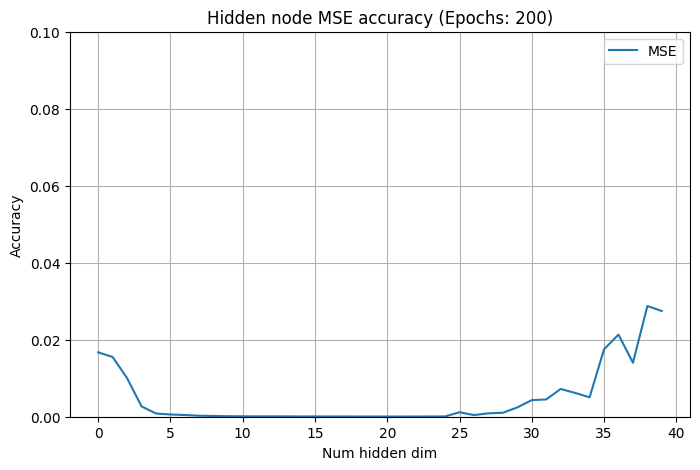

In [16]:
x = np.linspace(-5,5,21)
y = np.linspace(-5,5,21)

number_epochs = 200
hidden_nodes = 40
total_hidden_node_mse = []
num_iterations = 100
for a in range(num_iterations):
  hidden_node_mse = []
  for i in range(hidden_nodes):
    xx,yy = np.meshgrid(x,y)
    X_full, t_full = pattern_target_generator(xx,yy) # (2,len(x)*len(y)), (1,len(x)*len(y))
    w_history, v_history, zz, classification_accuracy_history, mse_history = backprop_gauss(X_full, t_full, hidden_dim=i)
    # fig = plt.figure()
    # ax = plt.axes(projection='3d')
    # ax.plot_surface(xx, yy, zz[-1,:,:], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_zlabel('z')
    # ax.set_title(f"Num hidden dimensions: {i}")
    # title = f'Backprop with two-layer perceptron network (Hidden layer: {i})'
    # plot_accuracy(mse_history, classification_accuracy_history, title)
    # print(f"MSE end: {mse_history[-1]}\n")
    hidden_node_mse.append(mse_history[-1])
  if a == 0:
    total_hidden_node_mse = np.array(hidden_node_mse).reshape(1,hidden_nodes)
  else:
    new_hidden_node_mse = np.array(hidden_node_mse).reshape(1,hidden_nodes)
    total_hidden_node_mse = np.vstack((new_hidden_node_mse, total_hidden_node_mse))
  # print(np.array(total_hidden_node_mse).shape)
  print(f"{(a+1)/num_iterations*100}%")
total_hidden_node_mse = np.array(total_hidden_node_mse).reshape(num_iterations, hidden_nodes)
plot_total_hidden_node_mse = np.mean(total_hidden_node_mse, axis=0)
# print(plot_total_hidden_node_mse.shape)
plt.figure(figsize=(8, 5))
plt.plot(plot_total_hidden_node_mse, label='MSE')
plt.title(f"Hidden node MSE accuracy (Epochs: {number_epochs})")
plt.xlabel('Num hidden dim')
plt.ylabel('Accuracy')
plt.ylim(0, 0.1)
plt.grid()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()


#### DATA SUBSAMPLING

[0.17851857 0.17442896 0.17494185 0.17695353 0.17819617 0.18337497
 0.18841991 0.19146488 0.19369725 0.19477718 0.19477809 0.19454438
 0.19432131 0.19391409 0.19348389 0.1932     0.19267743 0.19168837
 0.19031694 0.18865853 0.18694509 0.18563175 0.18532155 0.18601631
 0.18613759 0.18530301 0.18409356 0.18332066 0.18228542 0.18152366
 0.18110425 0.18091468 0.18080115 0.18062881 0.18027858 0.17967093
 0.17889535 0.1780872  0.17731362 0.17663836 0.17608974 0.17565779
 0.17528725 0.1749815  0.17473976 0.17450301 0.17423609 0.17394793
 0.17364051 0.17329592 0.17291595 0.1724943  0.17202886 0.17153675
 0.17104977 0.17060683 0.1702233  0.16988997 0.16960166 0.16936503
 0.16918408 0.1690459  0.16892589 0.16879774 0.16863604 0.16842447
 0.16816596 0.16788269 0.16760184 0.16733688 0.16708018 0.16680904
 0.16649962 0.16614183 0.16574927 0.16536258 0.16502343 0.16473498
 0.16448672 0.16429285 0.1641717  0.16407563 0.16394045 0.16374319
 0.16348602 0.16318434 0.16288268 0.16264808 0.16251743 0.1624

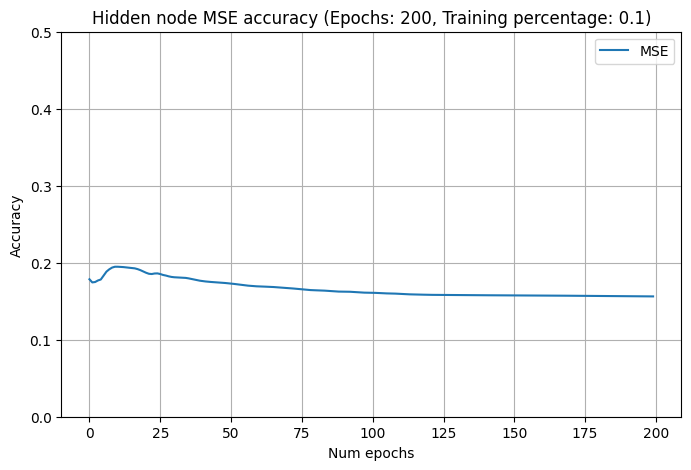

[0.18626333 0.18691672 0.1882467  0.18585056 0.18491016 0.1863211
 0.18911349 0.19038482 0.1902566  0.18972669 0.18870495 0.18712027
 0.1844947  0.1811203  0.17907668 0.17900892 0.17975633 0.17999759
 0.17862284 0.17608236 0.1736482  0.17211043 0.1716195  0.17134851
 0.17057412 0.16854753 0.16618226 0.16520687 0.16492887 0.16439861
 0.16400264 0.1640198  0.16358007 0.16302118 0.16296135 0.16318972
 0.16293265 0.16185364 0.16052013 0.15960304 0.159293   0.15927658
 0.15914661 0.15874307 0.15826077 0.15772857 0.15728663 0.15706779
 0.15686163 0.15620829 0.15520776 0.15466733 0.1547769  0.15530617
 0.15568793 0.1555637  0.15503957 0.15443805 0.15407882 0.15404407
 0.15415974 0.15420783 0.15401565 0.1536933  0.15345397 0.15336934
 0.15331884 0.15317493 0.15296473 0.15282501 0.15280458 0.15275346
 0.15253373 0.15225456 0.15214142 0.15225829 0.15242938 0.15243092
 0.15222824 0.15198862 0.15187928 0.15190971 0.15197222 0.15196939
 0.15190538 0.15184359 0.15181796 0.15181476 0.15181743 0.15181

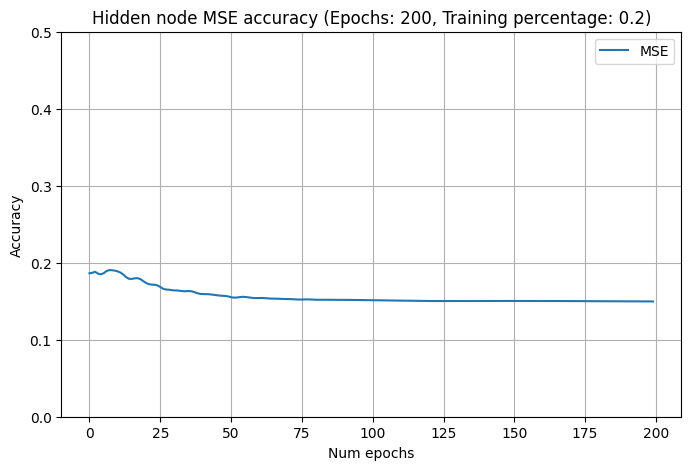

[0.17033979 0.16859666 0.16552982 0.17146127 0.17980154 0.18589732
 0.18991744 0.18973762 0.18964461 0.1879058  0.18726261 0.18762388
 0.18672723 0.18583498 0.18379529 0.18259733 0.18319341 0.18328301
 0.1834454  0.18295836 0.18177334 0.18062621 0.18032887 0.18045852
 0.18046871 0.17927125 0.1775789  0.17736382 0.17804166 0.17757135
 0.17590953 0.17513263 0.17561064 0.17539825 0.17355601 0.17216881
 0.17233708 0.17286001 0.17202991 0.1710735  0.17058408 0.17007705
 0.16940528 0.16888386 0.16861015 0.16803741 0.16723056 0.16665334
 0.16626787 0.16566653 0.16507025 0.16465108 0.16409529 0.16332533
 0.1628219  0.16272307 0.16239386 0.16158944 0.16081595 0.16045762
 0.16009082 0.15941813 0.15871664 0.15820577 0.15782564 0.15733644
 0.1567163  0.15619522 0.15581665 0.15545211 0.15502456 0.15457383
 0.15410041 0.15356797 0.15308586 0.15272525 0.15240169 0.15202923
 0.15170077 0.15146376 0.15122458 0.15093609 0.15064721 0.15039787
 0.15018095 0.14996954 0.14970785 0.14941603 0.14917487 0.1489

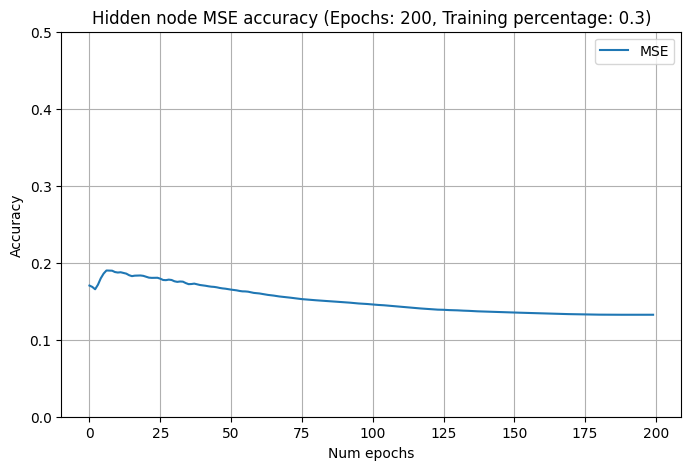

[0.16177872 0.16842158 0.17100645 0.16844593 0.16867762 0.16924063
 0.16726492 0.16551717 0.16420079 0.16144217 0.16149404 0.16324617
 0.16247846 0.15999577 0.15899285 0.15749399 0.15752207 0.15748387
 0.15761824 0.15639664 0.15453169 0.15301697 0.15258743 0.15142826
 0.1491315  0.14732548 0.14672537 0.14646056 0.14503531 0.14352492
 0.142101   0.14115068 0.14010458 0.14011889 0.13982259 0.13946071
 0.1387752  0.13836327 0.13785603 0.13718541 0.13659429 0.13664069
 0.1363467  0.13551528 0.13464277 0.13407368 0.13334651 0.13269844
 0.13230207 0.13173594 0.13103078 0.13062294 0.12990379 0.12909678
 0.12853589 0.12809135 0.12743246 0.12678504 0.12627118 0.12596222
 0.12552562 0.12489239 0.12419314 0.12364511 0.12307564 0.12249174
 0.12194269 0.12149914 0.12126552 0.12086416 0.12036788 0.12002372
 0.11972126 0.11930743 0.11886875 0.11851    0.11819561 0.11782951
 0.11735546 0.11686076 0.1167321  0.11673102 0.11644334 0.11592077
 0.11558452 0.11552114 0.11544277 0.11522541 0.11498586 0.1147

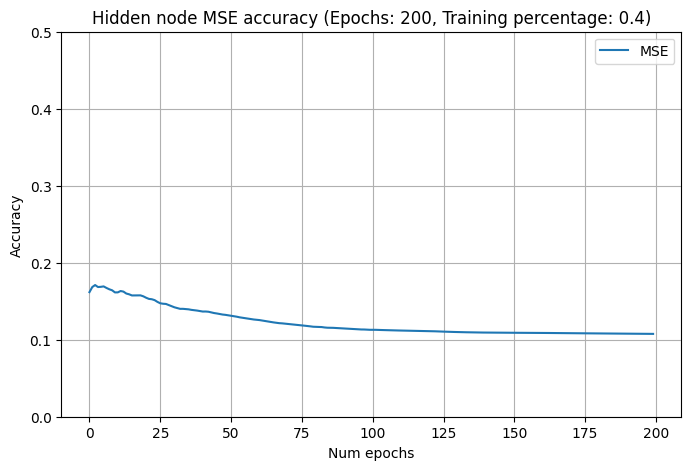

[0.17145885 0.16787795 0.17506876 0.17109311 0.17235662 0.17202563
 0.17054617 0.16753046 0.16586762 0.16365041 0.16034245 0.15982601
 0.15534946 0.1516285  0.1472744  0.14489501 0.14342586 0.14035075
 0.13472648 0.12857027 0.12539772 0.1219669  0.11663498 0.11097626
 0.10628291 0.10360205 0.10115594 0.09738323 0.09488831 0.09395076
 0.0922574  0.08878025 0.0864437  0.08435296 0.08299546 0.08206869
 0.08101396 0.07893224 0.07791181 0.07708523 0.07605152 0.07563294
 0.07539476 0.07496333 0.07430535 0.0741759  0.07430958 0.07434843
 0.07361626 0.07313504 0.07331657 0.0729181  0.07250676 0.07285056
 0.07254933 0.07184157 0.07199362 0.07180106 0.07114982 0.07137842
 0.07074323 0.07011928 0.06945963 0.06862625 0.06833433 0.06793675
 0.06764515 0.06760648 0.06728084 0.06702054 0.06707876 0.06696588
 0.06678188 0.06687374 0.06687574 0.06661032 0.06657363 0.0667197
 0.0664959  0.06617383 0.06616296 0.06604823 0.06577012 0.0657855
 0.06584375 0.06566377 0.0656091  0.06569233 0.06565487 0.065658

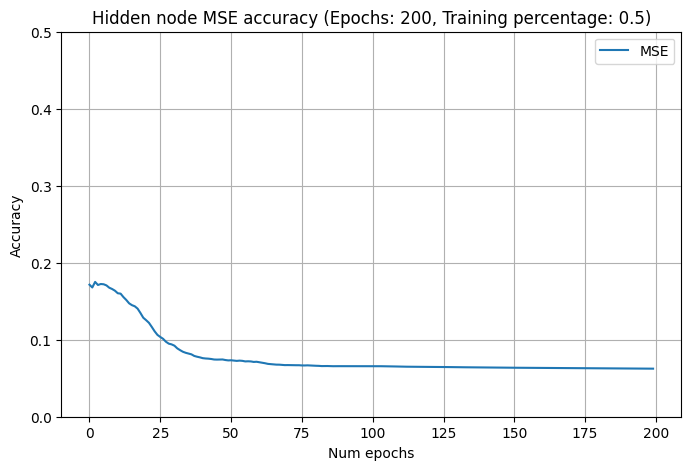

[0.16973701 0.16399145 0.16192089 0.17047037 0.17765901 0.17967025
 0.17753866 0.16928638 0.16034074 0.15074906 0.14024032 0.13216034
 0.12623163 0.11971737 0.11283639 0.10688035 0.0981743  0.09278275
 0.08718527 0.08125934 0.0756788  0.07436571 0.07271826 0.07101063
 0.06821998 0.06490263 0.06119275 0.06085105 0.05912119 0.05426597
 0.05072353 0.04880857 0.04766636 0.04603834 0.04405123 0.04362472
 0.04371412 0.04249396 0.04116469 0.03940559 0.03880198 0.03786913
 0.03699945 0.03646714 0.03540693 0.03436725 0.03394609 0.03361958
 0.03349851 0.03351583 0.03269884 0.03244045 0.03207568 0.03158416
 0.03131975 0.0314445  0.03088945 0.03018269 0.03003329 0.03008265
 0.02983777 0.0294719  0.02914351 0.02895997 0.02896823 0.0288337
 0.02892696 0.02895107 0.02829275 0.0279049  0.02811866 0.0278153
 0.02734175 0.02733956 0.02711289 0.02683928 0.02706035 0.02707919
 0.02700398 0.02716362 0.0269051  0.02666488 0.02679649 0.02648601
 0.02627034 0.02651107 0.02620092 0.02589642 0.0262344  0.026107

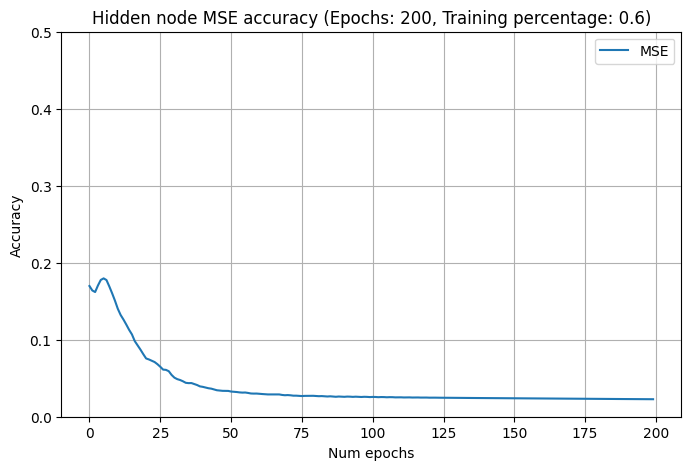

[0.15959828 0.15836788 0.14713235 0.15664957 0.15932586 0.15875634
 0.15189858 0.13773986 0.13014079 0.12168981 0.11608382 0.10982768
 0.10385707 0.10031138 0.09194856 0.08305591 0.0728764  0.06821031
 0.06261881 0.05855802 0.05420058 0.04916322 0.04405984 0.04040932
 0.03638984 0.03590057 0.03154348 0.02828265 0.02499069 0.02430003
 0.02439712 0.02326663 0.02354846 0.02333068 0.02183602 0.02152717
 0.02023335 0.01765593 0.01621501 0.01664555 0.01474324 0.01336987
 0.01456251 0.01483688 0.01491075 0.01409304 0.01245819 0.01189282
 0.01158113 0.01211778 0.01252435 0.01190284 0.01105179 0.01083145
 0.01081484 0.01022709 0.01012216 0.00993333 0.00999723 0.00991528
 0.00885302 0.0089356  0.00847531 0.00837879 0.00918439 0.00839231
 0.00860868 0.00794546 0.00789307 0.0077615  0.00708516 0.00712731
 0.00708938 0.00715868 0.00739353 0.00698196 0.00707532 0.00692311
 0.00676396 0.0069751  0.00668267 0.00647549 0.00640917 0.00644586
 0.00705636 0.00697215 0.00691335 0.00620999 0.00615077 0.0068

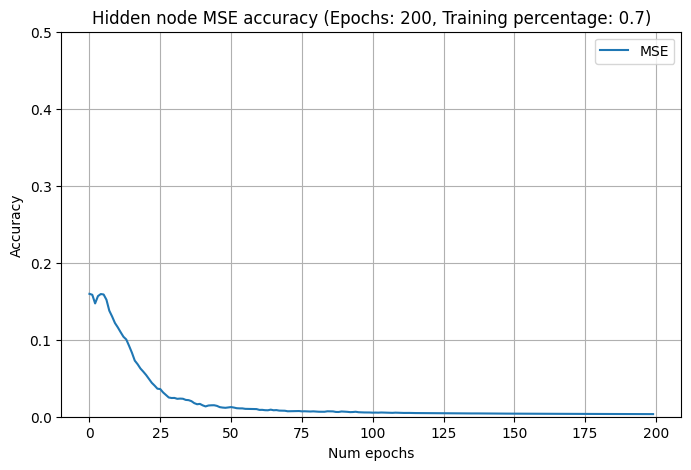

[0.13288263 0.12259598 0.1101581  0.10894145 0.10945759 0.11045391
 0.0950456  0.08628211 0.07746489 0.07183108 0.06470676 0.0559618
 0.05300482 0.04705918 0.04269444 0.03954912 0.03539477 0.03147222
 0.02721793 0.02577316 0.02276301 0.02119481 0.02091958 0.01617838
 0.01633924 0.01375128 0.01334463 0.01320285 0.01144386 0.01147093
 0.00970764 0.01004742 0.00992669 0.00960155 0.00859839 0.00816766
 0.00823421 0.0083549  0.00794845 0.00662845 0.00659456 0.00580119
 0.00622237 0.00633508 0.00488789 0.00543536 0.00670518 0.00471639
 0.00513269 0.00551647 0.00358772 0.00504437 0.00392066 0.00368919
 0.00337581 0.00355556 0.00341978 0.00249405 0.00341382 0.0026108
 0.00276766 0.00237871 0.00206637 0.00246584 0.00216177 0.00234813
 0.00224158 0.00166667 0.00222417 0.00173231 0.00164101 0.00198414
 0.00153915 0.00159875 0.00173965 0.00129892 0.00143204 0.00139776
 0.00124375 0.0013343  0.00118982 0.00118911 0.00121233 0.00107482
 0.00104883 0.00105606 0.00105661 0.00100628 0.00094727 0.000970

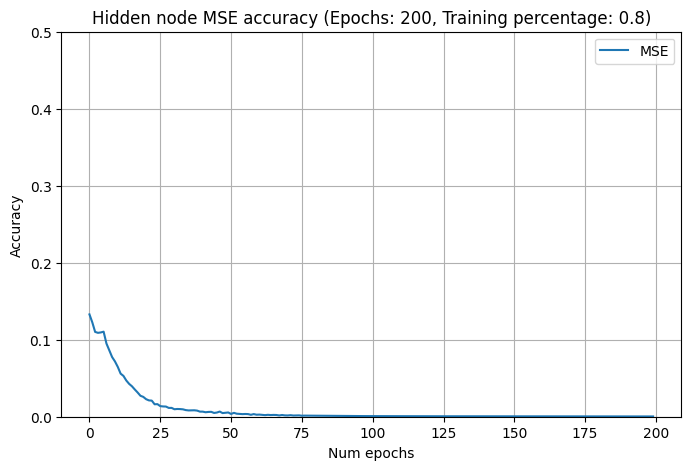

[1.42867349e-01 1.29731870e-01 1.22550339e-01 1.16722157e-01
 1.19925827e-01 1.13135477e-01 1.00968129e-01 9.23043374e-02
 8.43440915e-02 7.67453788e-02 6.81911034e-02 5.85067545e-02
 5.55496711e-02 5.33642349e-02 4.86648742e-02 4.74631133e-02
 3.88523406e-02 3.40354861e-02 3.62175068e-02 3.32001180e-02
 2.87864485e-02 2.53665292e-02 2.53331172e-02 2.28215668e-02
 2.09544697e-02 1.92109878e-02 1.57696996e-02 1.84330115e-02
 1.46113155e-02 1.58692944e-02 1.32807974e-02 1.31789314e-02
 1.38426208e-02 1.19167324e-02 1.13359743e-02 9.32234426e-03
 8.78010297e-03 1.13827358e-02 7.68755315e-03 1.03712199e-02
 1.07698302e-02 7.66662052e-03 7.85590540e-03 7.74315303e-03
 7.21116798e-03 6.65699684e-03 6.23222897e-03 6.14931546e-03
 5.76622234e-03 5.38709609e-03 4.79982392e-03 3.69939025e-03
 4.15911357e-03 4.18029036e-03 4.18312000e-03 4.08177981e-03
 3.76714951e-03 3.77043601e-03 2.54460556e-03 2.35936350e-03
 2.67041460e-03 2.29199931e-03 2.65380730e-03 2.38998610e-03
 1.85223561e-03 2.199605

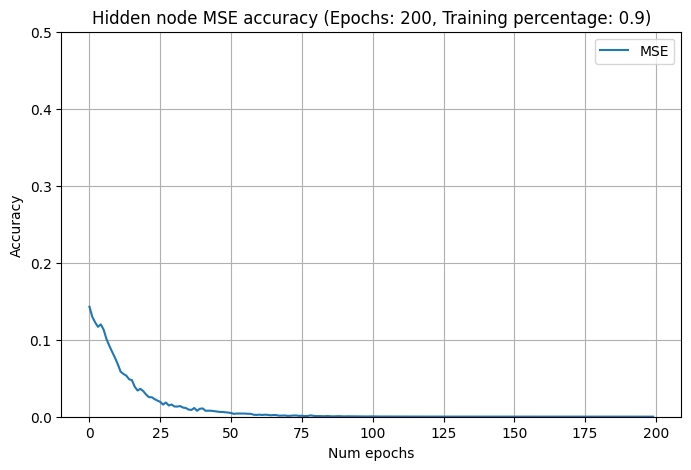

In [55]:
number_epochs = 200
hidden_nodes = 20
total_hidden_node_mse = []
num_iterations = 50
percentage = np.linspace(0.1, 0.9, 9)
for perc in percentage:
  for a in range(num_iterations):
    hidden_node_mse = []
    xx,yy = np.meshgrid(x,y)
    X_full, t_full = pattern_target_generator(xx, yy)
    w_history, v_history, zz, classification_accuracy_history, mse_history = backprop_gauss(X_full, t_full, hidden_nodes, perc)
    # fig = plt.figure()
    # ax = plt.axes(projection='3d')
    # ax.plot_surface(xx, yy, zz[-1,:,:], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_zlabel('z')
    # ax.set_title(f"Num hidden nodes: {hidden_nodes}")
    # title = f'Backprop with two-layer perceptron network (Hidden layer: {hidden_nodes}, Training percentage: {round(perc,1)})'
    # plot_accuracy_gauss(mse_history, title)
    # print(f"MSE end: {mse_history[-1]}\n")
    # hidden_node_mse.append(mse_history[-1])
    if a == 0:
      total_hidden_node_mse = np.array(mse_history)
    else:
      new_hidden_node_mse = np.array(mse_history)
      total_hidden_node_mse = np.vstack((new_hidden_node_mse, total_hidden_node_mse))
    # print(f"{(a+1)/num_iterations*100}%")
    # print(total_hidden_node_mse.shape)
  total_hidden_node_mse = np.array(total_hidden_node_mse)
  plot_total_hidden_node_mse = np.mean(total_hidden_node_mse, axis=0)
  # print(plot_total_hidden_node_mse.shape)
  print(plot_total_hidden_node_mse)
  plt.figure(figsize=(8, 5))
  plt.plot(plot_total_hidden_node_mse, label='MSE')
  plt.title(f"Hidden node MSE accuracy (Epochs: {number_epochs}, Training percentage: {round(perc,1)})")
  plt.xlabel('Num epochs')
  plt.ylabel('Accuracy')
  plt.ylim(0, 0.5)
  plt.grid()
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()
  plt.show()